In [1]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)
torch.manual_seed(42)

Definition of the architecture as seen in : https://arxiv.org/pdf/1811.08782.pdf

In [2]:
class DGM_layer(nn.Module):
    
    def __init__(self, in_features, out_feature, residual = False):
        super(DGM_layer, self).__init__()
        self.residual = residual
        
        self.Z = nn.Linear(out_feature,out_feature) ; self.UZ = nn.Linear(in_features,out_feature, bias=False)
        self.G = nn.Linear(out_feature,out_feature) ; self.UG = nn.Linear(in_features,out_feature, bias=False)
        self.R = nn.Linear(out_feature,out_feature) ; self.UR = nn.Linear(in_features,out_feature, bias=False)
        self.H = nn.Linear(out_feature,out_feature) ; self.UH = nn.Linear(in_features,out_feature, bias=False)
    

    def forward(self, x, s):
        z = torch.tanh(self.UZ(x)+self.Z(s))
        g = torch.tanh(self.UG(x)+self.G(s))
        r = torch.tanh(self.UR(x)+self.R(s))
        h = torch.tanh(self.UH(x)+self.H(s*r))
        return (1 - g) * h + z*s
        
    


In [3]:
class DGM_layer2(nn.Module):
    
    def __init__(self, in_features, out_features, residual = False):
        super(DGM_layer2, self).__init__()
        self.residual = residual
        self.in_features = in_features
        self.out_features = out_features
        
        self.Uz = nn.Parameter(torch.Tensor(in_features, out_features))
        self.Ug = nn.Parameter(torch.Tensor(in_features, out_features))
        self.Ur = nn.Parameter(torch.Tensor(in_features, out_features))
        self.Uh = nn.Parameter(torch.Tensor(in_features, out_features))
        
        self.Wz = nn.Parameter(torch.Tensor(out_features, out_features))
        self.Wg = nn.Parameter(torch.Tensor(out_features, out_features))
        self.Wr = nn.Parameter(torch.Tensor(out_features, out_features))
        self.Wh = nn.Parameter(torch.Tensor(out_features, out_features))

        self.bz = nn.Parameter(torch.Tensor(out_features))
        self.bg = nn.Parameter(torch.Tensor(out_features))
        self.br = nn.Parameter(torch.Tensor(out_features))
        self.bh = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_normal_(self.Uz)
        nn.init.xavier_normal_(self.Ug)
        nn.init.xavier_normal_(self.Ur)
        nn.init.xavier_normal_(self.Uh)
        nn.init.xavier_normal_(self.Wz)
        nn.init.xavier_normal_(self.Wg)
        nn.init.xavier_normal_(self.Wr)
        nn.init.xavier_normal_(self.Wh)
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.Wz)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bz,-bound, bound)
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.Wh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bg,-bound, bound)
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.Wr)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.br,-bound, bound)
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.Wh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bh,-bound, bound)
        
    def forward(self, x, s):
        z = torch.tanh(x @ self.Uz +  s @ self.Wz + self.bz )
        g = torch.tanh(x @ self.Ug +  s @ self.Wg + self.bg )
        r = torch.tanh(x @ self.Ur +  s @ self.Wr + self.br )
        h = torch.tanh(x @ self.Uh +  (s * r) @ self.Wh + self.bh  )
        
        s_next = (1 - g) * h + z*s
        if (self.residual == True) : s_next = s_next + s
        
        return s_next

In [4]:
class Dense_layer(nn.Module):
    def __init__(self, in_features, out_features):
        super(Dense_layer, self).__init__()
        
        self.W = nn.Parameter(torch.Tensor(in_features, out_features))
        self.b = nn.Parameter(torch.Tensor(out_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.W)

        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b,-bound, bound)
        
    def forward(self, x):
        s = x @ self.W + self.b
        return s

In [5]:
class DGM_net(nn.Module):
    def __init__(self, in_dim,out_dim, n_layers, n_neurons, residual = False):
        """ in_dim is number of cordinates + 1 
            out_dim is the number of output
            n_layers and n_neurons are pretty self explanatory
            make residual = true for identity between each DGM layers
        """
        super(DGM_net, self).__init__()
        self.in_dim = in_dim ; self.out_dim = out_dim
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.residual = residual

        self.first_layer = nn.Linear(in_dim, n_neurons)
        
        self.dgm_layers = nn.ModuleList([DGM_layer(self.in_dim, self.n_neurons,
                                                       self.residual) for i in range(self.n_layers)])
        self.final_layer = nn.Linear(n_neurons,out_dim)
    
    def forward(self,X,t):
        x = torch.cat((X,t),1)
        s = torch.tanh(self.first_layer(x))
        for i,dgm_layer in enumerate(self.dgm_layers):
            s = dgm_layer(x, s)
        
        return  self.final_layer(s)

In [6]:
# PDE parameters
r = 0.05            # Interest rate
sigma = 0.25        # Volatility
mu = 0.2            # Mean
lambd = (mu-r)/sigma
gamma = 1           # Utility decay

# Time limits
T0 = 0.0 + 1e-10    # Initial time
T  = 1.0            # Terminal time

# Space limits
S1 = 0.0 + 1e-10    # Low boundary
S2 = 1              # High boundary


# Merton's analytical known solution
def analytical_solution(t, x):
    return -np.exp(-x*gamma*np.exp(r*(T-t)) - (T-t)*0.5*lambd**2)

def analytical_dVdx(t,x):
    return gamma*np.exp(-0.5*(T-t)*lambd**2 + r*(T-t))*np.exp(-x*gamma*np.exp(r*(T-t)))

def analytical_dV2dxx(t,x):
    return -gamma**2*np.exp(-0.5*(T-t)*lambd**2 + 2*r*(T-t))*np.exp(-x*gamma*np.exp(r*(T-t)))

# Merton's final utility function
def utility(x):
    return -torch.exp(-gamma*x)

Definition of domain sampling and loss function from https://github.com/adolfocorreia/DGM/, adapted to pytorch

In [7]:
def sampler(N1, N2, N3):
    # Sampler #1: PDE domain
    t1 = np.random.uniform(low=T0 - 0.5*(T - T0),
                           high=T,
                           size=[N1,1])
    s1 = np.random.uniform(low=S1 - (S2 - S1)*0.5,
                           high=S2 + (S2 - S1)*0.5,
                           size=[N1,1])

    # Sampler #2: boundary condition
    t2 = np.zeros(shape=(1, 1))
    s2 = np.zeros(shape=(1, 1))
    
    # Sampler #3: initial/terminal condition
    t3 = T * np.ones((N3,1)) #Terminal condition
    s3 = np.random.uniform(low=S1 - (S2 - S1)*0.5,
                           high=S2 + (S2 - S1)*0.5,
                           size=[N3,1])
    
    t1=torch.tensor(t1, dtype=torch.float32, requires_grad=True).cuda()
    s1=torch.tensor(s1, dtype=torch.float32, requires_grad=True).cuda()
    t2=torch.tensor(t2, dtype=torch.float32, requires_grad=True).cuda()
    s2=torch.tensor(s2, dtype=torch.float32, requires_grad=True).cuda()
    t3=torch.tensor(t3, dtype=torch.float32, requires_grad=True).cuda()
    s3=torch.tensor(s3, dtype=torch.float32, requires_grad=True).cuda()
    return (t1, s1, t2, s2, t3, s3)

In [39]:
def Loss(model, t1, x1, t2, x2, t3, x3):
    # Loss term #1: PDE
    V = model(t1, x1)
    V_t = torch.autograd.grad(V.sum(), t1, create_graph=True, retain_graph=True)[0]
    V_x = torch.autograd.grad(V.sum(), x1, create_graph=True, retain_graph=True)[0]
    V_xx = torch.autograd.grad(V_x.sum(), x1, create_graph = True, retain_graph=True)[0]
    f = -0.5*lambd**2*V_x**2 + (V_t + r*x1*V_x)*V_xx

    L1 = torch.mean(torch.pow(f,2))

    # Loss term #2: boundary condition
    L2 = 0.0
    
    # Loss term #3: initial/terminal condition
    L3 = torch.mean(torch.pow((model(t3, x3) - utility(x3)),2))

    return L1, L2, L3


Model init and training

In [40]:
model = DGM_net(2,1,3,50)
model.cuda()
opt = torch.optim.RMSprop(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,gamma=0.99)

loss = nn.MSELoss()
# Number of samples
NS_1 = 1000
NS_2 = 0
NS_3 = 100


# Training parameters
steps_per_sample = 10
sampling_stages = 800

In [41]:
def train_model(model, optimizer, scheduler, num_epochs=100):
    since = time.time()
    model.train()
  # Set model to training mode
    
    for epoch in range(num_epochs):
        t1, x1, t2, x2, t3, x3 = sampler(NS_1, NS_2, NS_3) #
        scheduler.step()

        for _ in range(steps_per_sample) :

            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward
            L1, L2, L3 = Loss(model, t1, x1, t2, x2, t3, x3)
    
            loss = L1 + L2 + L3
            # backward + optimize
            loss.backward()
            optimizer.step()
            
        epoch +=1 
        if epoch % (num_epochs//100) == 0: print(f'epoch {epoch}, loss {loss.data}, L1 : {L1.data}, L3 : {L3.data}')
    time_elapsed = time.time() - since
    print(f"Training finished in {time_elapsed:.2f} for {num_epochs}.")
    print(f"The final loss value is {loss.data}")

In [ ]:
train_model(model, opt, scheduler, sampling_stages)

epoch 8, loss 0.0033979443833231926, L1 : 0.0011159833520650864, L3 : 0.0022819610312581062
epoch 16, loss 0.0012001283466815948, L1 : 0.0005589041975326836, L3 : 0.0006412240909412503
epoch 24, loss 0.0006277032662183046, L1 : 0.00024683267110958695, L3 : 0.0003808705660048872
epoch 32, loss 0.0004270496719982475, L1 : 0.00019579498621169478, L3 : 0.00023125468578655273
epoch 40, loss 0.005572431720793247, L1 : 0.0002664158819243312, L3 : 0.005306015722453594
epoch 48, loss 0.0006184724625200033, L1 : 0.00013213134661782533, L3 : 0.00048634110135026276
epoch 56, loss 0.002491056453436613, L1 : 0.0019670764449983835, L3 : 0.0005239798920229077
epoch 64, loss 0.00020922021940350533, L1 : 0.00011078317766077816, L3 : 9.843704901868477e-05
epoch 72, loss 0.0001490326103521511, L1 : 7.70638944231905e-05, L3 : 7.196871592896059e-05
epoch 80, loss 0.00021369736350607127, L1 : 0.0001515362673671916, L3 : 6.216109613887966e-05
epoch 88, loss 0.0009476918494328856, L1 : 0.00026076901121996343, 

epoch 704, loss 4.060705578012858e-06, L1 : 2.0192285319353687e-06, L3 : 2.0414772734511644e-06
epoch 712, loss 3.5425746318651363e-06, L1 : 1.9973495000158437e-06, L3 : 1.5452252455361304e-06
epoch 720, loss 3.7774907468701713e-06, L1 : 2.0088332348677795e-06, L3 : 1.768657398315554e-06
epoch 728, loss 3.3219098440895323e-06, L1 : 1.9767462617892306e-06, L3 : 1.3451635823003016e-06
epoch 736, loss 3.236369138903683e-06, L1 : 1.7805679135562968e-06, L3 : 1.4558012253473862e-06
epoch 744, loss 3.6585149700840702e-06, L1 : 1.9280137166788336e-06, L3 : 1.7305012534052366e-06
epoch 752, loss 3.929152171622263e-06, L1 : 1.8078019365930231e-06, L3 : 2.12135023502924e-06
epoch 760, loss 3.458781066001393e-06, L1 : 1.9030223938898416e-06, L3 : 1.5557585584247136e-06
epoch 768, loss 3.2644022667227546e-06, L1 : 2.015822019529878e-06, L3 : 1.2485802471928764e-06
epoch 776, loss 3.613412218328449e-06, L1 : 1.7604859294806374e-06, L3 : 1.8529262888478115e-06


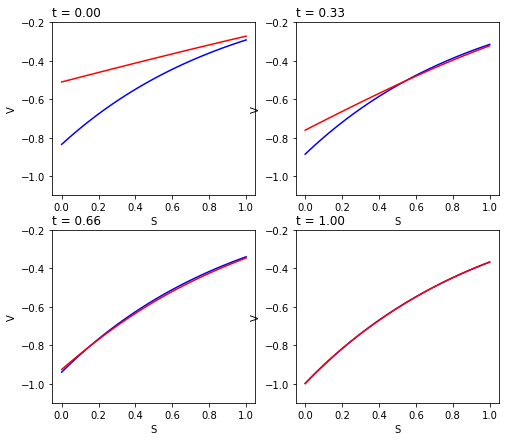

In [38]:
# Plot results
N = 41      # Points on plot grid

times_to_plot = [0*T, 0.33*T, 0.66*T, T]
tplot = np.linspace(T0, T, N)
xplot = np.linspace(S1, S2, N)

plt.figure(figsize=(8,7))
i = 1
for t in times_to_plot:
    solution_plot = analytical_solution(t, xplot)

    tt = t*np.ones_like(xplot.reshape(-1,1))
    
    tt_nn = torch.tensor(tt.reshape(-1,1), dtype=torch.float32).cuda()
    xplot_nn = torch.tensor(xplot.reshape(-1,1), dtype=torch.float32).cuda()
    nn_plot = model(tt_nn,xplot_nn).cpu()

    plt.subplot(2,2,i)
    plt.plot(xplot, solution_plot, 'b')
    plt.plot(xplot, nn_plot.data.numpy(), 'r')

    plt.ylim(-1.1, -0.2)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title("t = %.2f"%t, loc="left")
    i = i+1

plt.show()

test section

In [ ]:
for param in model.parameters():
    print(param.grad.data.sum())

In [ ]:
for param in model.parameters():
  print(param.data)

In [ ]:
for param in model.parameters():
  print(param.data)

In [ ]:
xplot.reshape(-1,1)

In [19]:
        t1, x1, t2, x2, t3, x3 = sampler(NS_1, NS_2, NS_3) #
